In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mp
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

<b>Elisa Perini</b><br>
CM2007, VT22, Assignment 1<br>
KTH<br>
11.2.2022<br>
<br>

<h1>Import data </h1>
Dataset: https://archive.ics.uci.edu/ml/datasets/diabetes <br>
Your goal is to use this data to develop an ML model that can predict any individual's Blood Glucose Value, given time and activity (as specified in the data description) as input. Also try to understand, and mine for any patterns for the effect of exercise on Blood Glucose.<br>
The data will be first imported form 70 separate fileas and concantenated into a pandas dataframe.

In [2]:
# combine all data table together into one dataframe
for i in range(1,71):
    if i == 1:
        patient = "01"
        filename = 'Diabetes-Data/data-'+ patient
        rawdata = pd.read_table(filename, names = ["date", "time","code", "value" ])
        rawdata['patient'] = patient
    else:
        if i < 10 and i != 1:
            patient = "0" + str(i)
        else:
            patient = str(i)
        filename = 'Diabetes-Data/data-' + patient
        temp = pd.read_table(filename, names = ["date", "time","code", "value" ])
        temp['patient'] = patient

        rawdata = pd.concat([rawdata, temp])

data = rawdata.copy()

# change patient into an integer to save memory space and computation time
data['patient'] = pd.to_numeric(data['patient'], errors='coerce', downcast="integer")

data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29330 entries, 0 to 340
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     29297 non-null  object
 1   time     29330 non-null  object
 2   code     29330 non-null  int64 
 3   value    29297 non-null  object
 4   patient  29330 non-null  int8  
dtypes: int64(1), int8(1), object(3)
memory usage: 1.1+ MB


<AxesSubplot:>

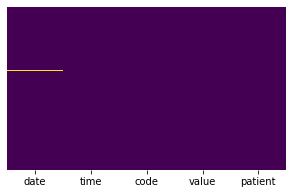

In [3]:
# Visualisation of missing values
plt.figure(figsize=(5, 3))
sns.heatmap(data.isnull(), yticklabels=False, cmap='viridis', cbar=False)

In [4]:
#useful functions to calculate missing values
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")

def perc_missing(df):
    '''prints out columns with missing values with its %'''
    for col in df.columns:
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
            
#calculate missing values in the rawdata
print("Missing values")
print(missing_cols(data))
print("____")
print(perc_missing(data))

Missing values
date => 33
value => 33
None
____
date => 0.11%
value => 0.11%
None


<h1>Data cleaning </h1>

In [5]:
# remove rows with missing values
data = data.dropna()
print(data.info())

#drop non numeric values of "value" and change value from object to float, then drop N/A values
data['value'] = pd.to_numeric(data['value'], errors='coerce')
print(missing_cols(data))
print(perc_missing(data))
print(" ")
data = data.dropna()
data['value'] = data['value'].astype(int)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29264 entries, 0 to 340
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     29264 non-null  object
 1   time     29264 non-null  object
 2   code     29264 non-null  int64 
 3   value    29264 non-null  object
 4   patient  29264 non-null  int8  
dtypes: int64(1), int8(1), object(3)
memory usage: 1.1+ MB
None
value => 8
None
value => 0.03%
None
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29256 entries, 0 to 340
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     29256 non-null  object
 1   time     29256 non-null  object
 2   code     29256 non-null  int64 
 3   value    29256 non-null  int64 
 4   patient  29256 non-null  int8  
dtypes: int64(2), int8(1), object(2)
memory usage: 1.1+ MB
None


In [6]:
#check for dublicates
data.duplicated().any()

True

In [7]:
# drop duplicates
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29249 entries, 0 to 340
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     29249 non-null  object
 1   time     29249 non-null  object
 2   code     29249 non-null  int64 
 3   value    29249 non-null  int64 
 4   patient  29249 non-null  int8  
dtypes: int64(2), int8(1), object(2)
memory usage: 1.1+ MB


<h3>Dropping values:</h3>
<ol>
    <li>dropping rows that are missing (for instance weird format): 66 rows with no date or value dropped</li>
    <li>dropping rows that have a wrong numeric format in the value column: 8 rows dropped</li>
    <li>dropping duplicates: 7 rows dropped
</ol>
For points 1 and 2, the values were dropped, because they cannot really be used in the model, Duplicates were dropped because we do not want to count the same thing multiple times. Data went from 29330 rows to 29256 by dropping na:s and values with a wrong numeric format.<br>
After dropping duplicates: 29249 rows left.

In [8]:
# create timestamp variable (timeseries) and drop invalid date formats
data['timestamp'] = pd.to_datetime(data['date'] + ' ' + data['time'], errors='coerce')
print(missing_cols(data))
print(perc_missing(data))
print(" ")
data = data.dropna()
print(data.info())

timestamp => 12
None
timestamp => 0.04%
None
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29237 entries, 0 to 340
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       29237 non-null  object        
 1   time       29237 non-null  object        
 2   code       29237 non-null  int64         
 3   value      29237 non-null  int64         
 4   patient    29237 non-null  int8          
 5   timestamp  29237 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), int8(1), object(2)
memory usage: 1.4+ MB
None


A timestamp varibale is also created. Dropping the numeric values with a wrong format, because they consist in only 0,04% of the data. Mostly they are just dates where the user clearly inputted the wrong format (i.e. month and day inversed or time = 188:00)<br>
Data has now 29237 rows.

<h1>Method 1: grouping by patient and timestamp, and taking the max glucose value</h1>
Has sightly lower r² scores and higher RMSE and MAE than method 2, but has the benefit of not overwriting some of the meal or insulin codes.<br>
Commmented, because for some reason it messed up with the second method, if the second method was chosen later.

In [9]:
#data1 = data

In [10]:
# delete insulin measurement values and replace them with nan:s
#conditions = [(data1['code'] == 33), (data1['code'] == 34), (data1['code'] == 35)]
#choices = [np.nan, np.nan, np.nan]
#data1['value'] = np.select(conditions, choices, default=data1['value'])
#data1

In [11]:
# assign the maximal glucose values to the rows with the same patient and time stamp
#data1['glucose'] = data.groupby(['patient', 'timestamp'])['value'].transform(max)
#data1

In [12]:
# put NaNs back to glucose column, needed later to interpolate missing values
#data1['glucose'] = data1['glucose'].replace(0, np.nan)

In [13]:
# plot repatition of blood glucose values
#plt.figure(figsize=(5, 3))
#data1['glucose'].hist(bins=100)
#plt.xlabel('blood glucose value in mg/dL')
#plt.ylabel('instances')
#plt.title('Repartition of blood glucose values')

In [14]:
#convert time column into mins
#data1['time'] = data1['timestamp'].apply(lambda x: x.hour*60 + x.minute)

In [15]:
#drop unnecessary columns
#data1 = data1.drop(columns=['date', 'value', 'patient'])

<h1>Method 2: grouping by patient and timestamp, and aggregating by timestamp</h1>
The downside of this method is that some meal or insulin codes get overwritten, but it performs slightly better than method 1. It is also necessary to perform some more complex models, that give out better results, later.<br>
The idea is to aggregate the values with the same timestamp in the same row. Many of these rows are actually insulin injection and glucose measurements that are performed at the same time. The multiple vlaues in the value column will then be overcast to the correct column, <em>glucose</em> for glucose measurements and <em>insulin</em> for insulin intake.

In [16]:
data2 = data

In [17]:
# aggregate the data by patient and timestamp
data2 = data.groupby(['patient', 'timestamp'], as_index=False).agg({"time":list, "code":list, "value":list})
data2.head()

,patient,timestamp,time,code,value
0,1,1991-04-21 09:09:00,"[9:09, 9:09, 9:09]","[58, 33, 34]","[100, 9, 13]"
1,1,1991-04-21 17:08:00,"[17:08, 17:08]","[62, 33]","[119, 7]"
2,1,1991-04-21 22:51:00,[22:51],[48],[123]
3,1,1991-04-22 07:35:00,"[7:35, 7:35, 7:35]","[58, 33, 34]","[216, 10, 13]"
4,1,1991-04-22 13:40:00,[13:40],[33],[2]


Aggregating rows if they have the same timestamp and patient allows us to join under one timestamp the insulin values from insulin injections (codes 33, 34 and 35) and glucose values from the glucose measurements (codes 48, 57-64) that happened at the same time.<br>
Grouping the rows made data go from 29237 rows to 18319 rows.<br>

In [18]:
#convert time column into mins
data2['time'] = data2['timestamp'].apply(lambda x: x.hour*60 + x.minute)

# take codes out of the list in the code category
data2['cleaned_code'] = data2['code'].apply(lambda x: x[-1]) #x[-1] seems to give out better model than x[0]

The following bit of code allows to take out the values and codes out of the lists in the columns code and value. From there, they are inserted in the right column.<br>
For instance, if at one timestamp we have the code 59 and 33, this code 59 will be copied in the same row in the column <em>code_glucose</em>, indicating that a glucose measurement has taken place. The blood glucose value will be copied in the column <em>glucose</em>. The code 33 will be copied in the column <em>code_insulin</em>, indicating that an insulin injection has taken place, and the value of the insulin injection will be copied in the column <em>insulin</em>.

In [19]:
# part not so relevant for the assignement, but important if we want to improve the model
# code arrays
codes_exercise = [69, 70, 71]
codes_insulin = [33, 34, 35]
codes_glucose_measurement = [48, 57, 58, 59, 60, 61, 62, 63, 64]
codes_meals = [66, 67, 68]
codes_other = [65, 72]


for data_index, codes in enumerate(data2["code"]):
    counter = 0 

    for code in codes: #[row, column]

        if code in codes_meals:
            data2.loc[data_index, 'code_meal'] = code
            if code == 66: #typical meal
                data2.loc[data_index, 'meal'] = 2
            if code == 67: #more than normal meal
                data2.loc[data_index, 'meal'] = 3
            if code == 68: #less than normal meal
                data2.loc[data_index, 'meal'] = 1

        elif code == 65:
            data2.loc[data_index, 'hypo_symptoms'] = 1 # 1 = true, 0 = false
        elif code == 72:
            data2.loc[data_index, 'other'] = 1 # 1 = true, 0 = false
        
        elif code in codes_exercise:
            data2.loc[data_index, 'code_exercise'] = code
            if code == 69: #typical exercise activity
                data2.loc[data_index, 'exercise'] = 2
            if code == 70: #more than normal ex activity
                data2.loc[data_index, 'exercise'] = 3
            if code == 71: #less than normal ex activity
                data2.loc[data_index, 'exercise'] = 1

        # separate insulin measurement values form glucose measurement
        elif code in codes_insulin:
            data2.loc[data_index, 'code_insulin'] = code
            data2.loc[data_index, 'insulin'] = data2["value"][data_index][counter]

        elif code in codes_glucose_measurement:
            data2.loc[data_index, 'code_glucose'] = code
            data2.loc[data_index, 'glucose'] = data2["value"][data_index][counter]

        counter=+1

print(missing_cols(data2))

code_glucose => 4802
glucose => 4802
code_insulin => 8065
insulin => 8065
hypo_symptoms => 17991
code_meal => 17807
meal => 17807
other => 18225
code_exercise => 18014
exercise => 18014
None


<AxesSubplot:>

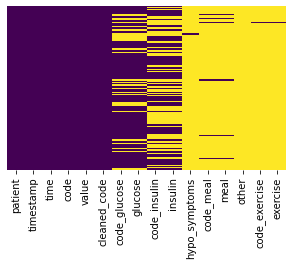

In [20]:
# Visualization of missing values
plt.figure(figsize=(5, 3))
sns.heatmap(data2.isnull(), yticklabels=False, cmap='viridis', cbar=False)

There is still a lot of missing glucose values, even when the data was grouped by patient and timestamp. The missing values in the <em>code_</em>, <em>other</em>, <em>meal</em>, <em>exercise</em> and <em>hypo_symptoms</em> will be dealt with in the following code blocks.

In [21]:
#drop columns code, value and patient, because they aren't relevant later
data2 = data2.drop(columns=['code', 'value', 'patient'])

# check for unrealistic values of blood glucose
data2[data2.glucose < 5]
# drop all rows that have blood glucose = 0
data2 = data2[data2.glucose != 0]

# rename column values
data2 = data2.rename(columns={'cleaned_code': 'code'})

#drop non valid codes
data2 = data2[data2['code'] != 36]
data2 = data2[data2['code'] != 56]

data2.head()

,timestamp,time,code,code_glucose,glucose,code_insulin,insulin,hypo_symptoms,code_meal,meal,other,code_exercise,exercise
0,1991-04-21 09:09:00,549,34,58.0,100.0,34.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-04-21 17:08:00,1028,33,62.0,119.0,33.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1991-04-21 22:51:00,1371,48,48.0,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-04-22 07:35:00,455,34,58.0,216.0,34.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1991-04-22 13:40:00,820,33,NaN,NaN,33.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


Dropping the 2 values with a blood glucose of 0, because the values are unrealistic. The rows with codes that weren't supposed to exist are also dropped.

In [22]:
#filling code values with 0 (where 0 ≃ false)
data2 = data2.fillna(0)
data2.head()

,timestamp,time,code,code_glucose,glucose,code_insulin,insulin,hypo_symptoms,code_meal,meal,other,code_exercise,exercise
0,1991-04-21 09:09:00,549,34,58.0,100.0,34.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1991-04-21 17:08:00,1028,33,62.0,119.0,33.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1991-04-21 22:51:00,1371,48,48.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1991-04-22 07:35:00,455,34,58.0,216.0,34.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1991-04-22 13:40:00,820,33,0.0,0.0,33.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# put NaNs back to glucose column, needed later to interpolate missing values
data2['glucose'] = data2['glucose'].replace(0, np.nan)

#replace code 48 with 57, because both codes mean the same thing
data2['code_meal'] = data2['code_meal'].replace(48, 57)
data2['code'] = data2['code'].replace(48, 57)
data2.head()

,timestamp,time,code,code_glucose,glucose,code_insulin,insulin,hypo_symptoms,code_meal,meal,other,code_exercise,exercise
0,1991-04-21 09:09:00,549,34,58.0,100.0,34.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1991-04-21 17:08:00,1028,33,62.0,119.0,33.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1991-04-21 22:51:00,1371,57,48.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1991-04-22 07:35:00,455,34,58.0,216.0,34.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1991-04-22 13:40:00,820,33,0.0,NaN,33.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


It was chosen to assign 0 to data rows that didn't have insulin intake, whereas missing glucose values were filled with nan:s, because no measurement does not mean no blood glucose. For the code categories, the missing values were filled with 0, as if to have a binary false.

In [24]:
# change type of columns --> saves memory and space
    # code columns --> category
    # insulin column --> integer
cols_cat = ['code_glucose', 'code_insulin', 'code', 'other', 'hypo_symptoms',
            'code_meal','meal', 'code_exercise', 'exercise']
cols_int = ['insulin']
data2[cols_int] = data2[cols_int].astype(int)
data2[cols_cat] = data2[cols_cat].astype('category')
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18198 entries, 0 to 18318
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      18198 non-null  datetime64[ns]
 1   time           18198 non-null  int64         
 2   code           18198 non-null  category      
 3   code_glucose   18198 non-null  category      
 4   glucose        13516 non-null  float64       
 5   code_insulin   18198 non-null  category      
 6   insulin        18198 non-null  int64         
 7   hypo_symptoms  18198 non-null  category      
 8   code_meal      18198 non-null  category      
 9   meal           18198 non-null  category      
 10  other          18198 non-null  category      
 11  code_exercise  18198 non-null  category      
 12  exercise       18198 non-null  category      
dtypes: category(9), datetime64[ns](1), float64(1), int64(2)
memory usage: 873.1 KB


<h3>Structure of data2 now:</h3>
<ul>
    <li>timestamp</li>
    <li>time in minutes</li>
    <li>code, categorical data [33-35, 57-72]</li>
    <li>code_glucose, categorical data [57-64], or every time a glucose measurement took place</li>
    <li>glucose: blood glucose value in mg/dL</li>
    <li>code_insulin: categorical data [33-35]</li>
    <li>insulin: insulin intake value, unspecified units</li>
    <li>hypo_symptoms: categorical value, 0 false, 1 true</li>
    <li>code_meal: categorical value [66-68]</li>
    <li>meal: categorical value, 0 = no meal, 1 = less than normal meal, 2 = typical meal, 3 = more than normal meal</li>
    <li>other: categorical value, 0 = false, 1 = true</li>
    <li>code_exercise: categorical value [69-71]</li>
    <li>exercise: categorical value, 0 = no exercise, 1 = less than normal exercise, 2 = typical exercise, 3 = more than normal exercise</li>
</ul>
    

<AxesSubplot:>

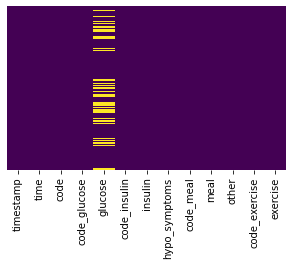

In [25]:
# visualising missing values
plt.figure(figsize=(5, 3))
sns.heatmap(data2.isnull(), yticklabels=False, cmap='viridis', cbar=False)

In [26]:
print(missing_cols(data))
print("----")
print(perc_missing(data))

no missing values left
None
----
None


The only missing values are glucose values. Since there are quite a lot of them, they cannot just be deleted with <em>df.dropna()</em>, it needs to be somewhat dealt with, before creating the model. This is happening later below, these values will be extrapolated from the existing data.

Text(0.5, 1.0, 'Repartition of blood glucose values')

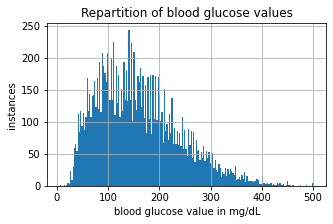

In [27]:
# plot repatition of blood glucose values
plt.figure(figsize=(5, 3))
data2['glucose'].hist(bins=200)
plt.xlabel('blood glucose value in mg/dL')
plt.ylabel('instances')
plt.title('Repartition of blood glucose values')

The histogram above shows that the most of the values are concentrated around 100 and 200. The shape of the histogram might suggest a logarithmic tranformation of the data. This was tried out, but did not particularly improve the model.

<h1>Imputing values / dealing with NaNs </h1>

There are a lot missing values in the glucose column (about 26%), cannot just be erased from the dataframe.
NaNs cannot be used in the model.

In [28]:
#choose dataset
data = data2

<h3>Imputation</h3>

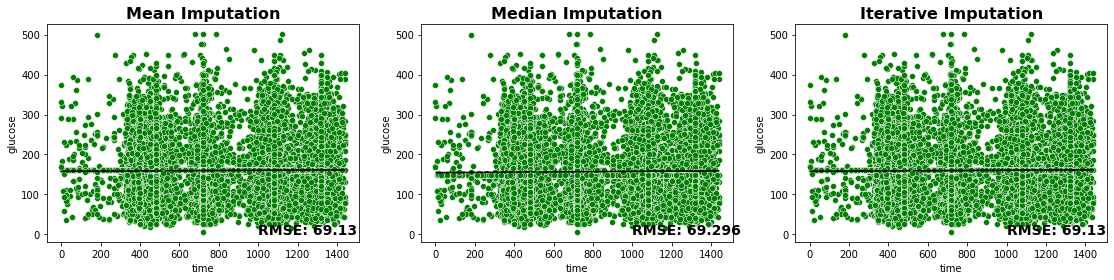

In [29]:
cont_feats = [col for col in data.columns if data[col].dtype == 'float64']

# Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')
mean_imputed = mean_imputer.fit_transform(data[cont_feats] )
df_mean_imputed = pd.DataFrame(mean_imputed, columns=cont_feats)

# Median Imputation
median_imputer = SimpleImputer(strategy='median')
median_imputed = median_imputer.fit_transform(data[cont_feats] )
df_median_imputed = pd.DataFrame(median_imputed, columns=cont_feats)

# Iterative Imputation
iter_imputer = IterativeImputer(random_state=42)
iter_imputed = iter_imputer.fit_transform(data[cont_feats] )
df_iter_imputed = pd.DataFrame(iter_imputed, columns=cont_feats)

# Plotting a comparison between the different strategies
# /!\ only works with data = data2
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(19, 4))
axes = np.reshape(axes, -1)

dfs = [df_mean_imputed, df_median_imputed, df_iter_imputed]
titles = ['Mean Imputation', 'Median Imputation', 'Iterative Imputation']

for i, df in enumerate(dfs):
    # Plotting the data
    x = data.time
    y = df.glucose
    sns.scatterplot(x, y, ax=axes[i], color='green')
    
    # Fitting and plotting a linear regression line
    m, b = np.polyfit(x, y, 1)
    linreg = m*x + b
    axes[i].plot(x, linreg, color='black', linestyle='dashed')
    
    # Setting the titles and including the RMSE values
    axes[i].set_title(titles[i], fontsize=16, fontweight='bold')
    rmse = round(mean_squared_error(y, linreg, squared=False), 3)
    axes[i].text(1000, 1, f'RMSE: {rmse}', fontsize=14, fontweight='bold')

No big difference between different imputation types.<br>
Do not make that much sense, because we are assuming a linear repartition of values, which is not really the case here anyways. This is why the pandas interpolation mathod was chosen<br>
<h3>Interpolation</h3>

In [30]:
#interpolation of data
data['glucose'] = data['glucose'].interpolate(method='nearest', limit_direction='forward')

Ways to deal with missing values: <br>
<ul>
    <li>polynomial interpolation --> 2nd and 3rd degree give out some negative glucose values --> unrealistic</li>
    <li>linear interpolation</li>
    <li>imputation (mean, median or iterative) --> no real difference between them, not used because assigns values close to the linear trend, and the data is not linear</li>
</ul>
Interpolation of data was used, because it made more sense to interpolate the data based on the nearest existing values than imputing them from a quite randomly chosen linear fit to the data. Multiple interpolation types were tried and the method <em>nearest</em> provided the best results.<br>
In the data, for those time both insulin intake and glucose measurement do not happen under the same timesatmp, insulin intake usually happens just after the glucose measurement, which also makes a lot of sense: first one checks the blood glucose, then one adjust the insulin intake in consequence. This means that a lot of the missing blood glucose values, happen just after the actual blood glucose measurement, so we can assume that they are very similar. And that is why using the nearest method, in the forward direction, which just fills nan:s with the nearest value with a smaller index, makes the most sense.<br>
Obviously some assumptions are made, because the dataset is not perfect, so not always there will be a blood glucose measurement before an event with a blood glucose measurement.

[Text(0.5, 0, 'code'), Text(0, 0.5, 'time in minutes')]

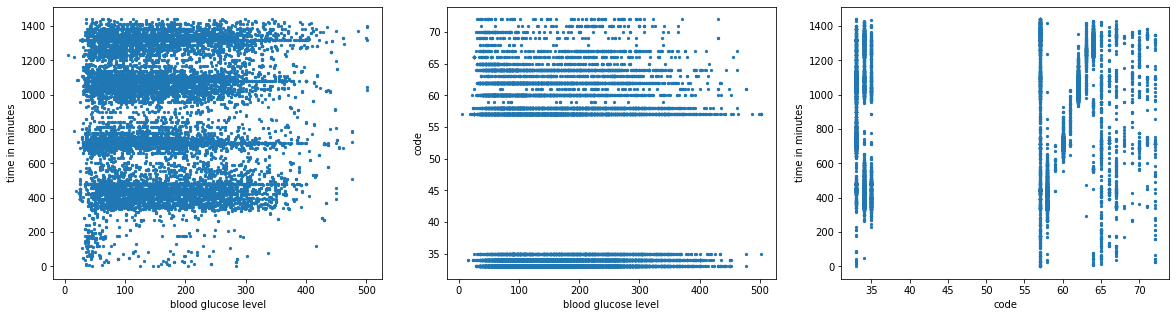

In [31]:
# Plots for visualizing the data
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axes = np.reshape(axes, -1)

axes[0].scatter(data['glucose'], data['time'], s=5)
axes[0].set(xlabel="blood glucose level",ylabel="time in minutes")
axes[1].scatter(data['glucose'], data['code'], s=5)
axes[1].set(xlabel="blood glucose level",ylabel="code")
axes[2].scatter(data['code'], data['time'], s=5)
axes[2].set(xlabel="code",ylabel="time in minutes")

In [32]:
print(missing_cols(data))
print(perc_missing(data))

# drop any leftover NaNs, for instance the last 3 rows, depending on the chosen method of interpolation
data = data.dropna()

glucose => 3
None
glucose => 0.02%
None


potential leftover NaNs are dropped, because the used models cannot handle missing values.

<h1>Splitting the data</h1>
The data is split into a training and test set. <em>get_dummies</em> converts categorical data into dummy variables. Random forest algorithms don't usually deal well with categorical variables (although here it still works somewhat since the variables are numerical, even though they are categorizing the data), so it is best to turn them into columns of 0 and 1. This also makes the mean absolute error in the model a bit smaller.

In [33]:
y = data['glucose']

# Assign feature variables
X1 = data.time
X2 = pd.get_dummies(data.code)
# Merge time and code into one array
X = np.c_[X1, X2]
# Drop unspecified to avoid collinearity (Dummy trap), not needed here, because no unspecified columns

# for data = data1:
#X = data[['time', 'code']]

# train-test splitting of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=1)

<h1>ANOVA</h1>
The analysis of variance is used to determine the effect that the independent variables have on the systemic variable in a regression. The higher the score the more influence said variable has on the dependent variable (blood glucose here).

Feature time: 1.6560285690882124
Feature 33: 1.4062789750612643
Feature 34: 1.1617818070360924
Feature 35: 1.4780738940596398
Feature 57: 1.4912609532178962
Feature 58: 1.1669093157064143
Feature 59: 0.8728785177400699
Feature 60: 1.3902379520456207
Feature 61: 2.921538856875229
Feature 62: 1.0410616229478045
Feature 63: 1.4237775548303049
Feature 64: 1.209146756948187
Feature 65: 1.7180520587841335
Feature 66: 3.2626829714710346
Feature 67: 1.9515063656791098
Feature 68: 0.9853050206555788
Feature 69: 0.9963667024817159
Feature 70: 1.249045494913815
Feature 71: 1.205097490346329
Feature 72: 1.326239818136955


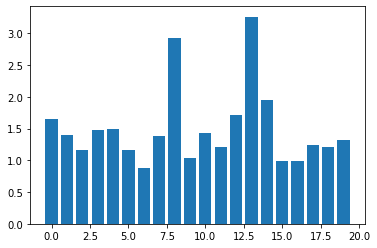

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# configure to select all features
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)


# what are scores for the features
dummy_names = [ 'time', 33, 34, 35, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
for i in range(len(fs.scores_)):
    print('Feature ' + str(dummy_names[i]) + ": " + str(fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

As can be seen none of the features analyzed with ANOVA give any significant score. All factors seem to be quite random.<br>
Feature 0 is time, the following features the dummies of the various codes.

<h1>Linear Regression</h1>

As seen in various plots, data is not really linear, so not very well suited.<br>
To evaluate the models, r² score, root mean squared error (RMSE) and mean absolute error (MAE) were used:<br>
<ul>
    <li>The MAE is the average error between predicted and actual blood glucose level.</li>
    <li>The RMSE is the standard deviation of the difference between the predicted and actual blood glucose level.</li>
    <li>r² or coefficient of determination indicates how well the data fits to the model.</li>
</ul>

In [35]:
# MODEL

#building model
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

#Predicting the target values of the test set
y_pred_linreg = linreg.predict(X_test)


# MODEL EVALUATION

#r² score
print("r² score: ", format(r2_score(y_test, y_pred_linreg), '.3f'))

# MSE (means squared error) & RMSE (Root Mean Square Error)
print("MSE: ", format(mean_squared_error(y_test, y_pred_linreg),'.3f'))
print("RMSE: ", format(np.sqrt(mean_squared_error(y_test, y_pred_linreg)),'.3f'))

#MAE (Mean Absolute Error)
print("MAE: ", format(mean_absolute_error(y_test, y_pred_linreg), '.3f'))

r² score:  0.044
MSE:  6555.538
RMSE:  80.966
MAE:  66.068


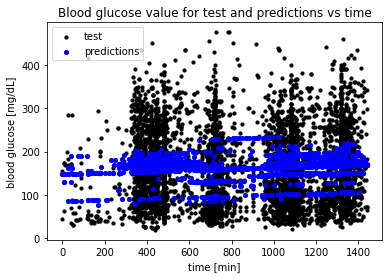

In [72]:
# Plot outputs
plt.scatter(X_test[:,0], y_test, color="black", label='test', s=10)
plt.scatter(X_test[:,0], y_pred_linreg, color="blue", linewidth=2, label='predictions', s=10)
plt.ylabel('blood glucose [mg/dL]')
plt.xlabel('time [min]')
plt.title("Blood glucose value for test and predictions vs time")
plt.legend()
plt.show()

As can be seen from the r² score and from the plot, the data does not fit to the modeal, and the errors are quite high, especially if we consider that blood glucose is spread out between 0 and 400 here. As can be seen in the plot, the model just predicts blood glucose values around 100-200 for any time and code.

<h1>Random Forest Regressor</h1>
As in the  <a href="https://www.sciencedirect.com/science/article/pii/S2405959516301126">paper</a> by Juan Li, Chandima Fernando, a Random forest regressor was used.

<h3>Model</h3>

In [37]:
#instantiation of the model
#parameters based on the gridsearch performed below, to find the optimal amount of estimators and depth
regr = RandomForestRegressor(n_estimators = 400, random_state = 1, max_depth = 15)

# Fitting the Random Forest Regression model to the data
regr.fit(X_train, y_train)

# Predicting the target values of the test set
y_pred_rfr = regr.predict(X_test)

<h3>Model evaluation </h3>

In [38]:
#r² score
print("r² score: ", format(r2_score(y_test, y_pred_rfr), '.3f'))

# MSE (means squared error) & RMSE (Root Mean Square Error)
print("Mean squared error: ", format(mean_squared_error(y_test, y_pred_rfr),'.3f'))
print("Root mean squared error: ", format(np.sqrt(mean_squared_error(y_test, y_pred_rfr)),'.3f'))

#MAE (Mean Absolute Error)
print("Mean absolute error: ", format(mean_absolute_error(y_test, y_pred_rfr), '.3f'))

r² score:  0.062
Mean squared error:  6432.393
Root mean squared error:  80.202
Mean absolute error:  64.766


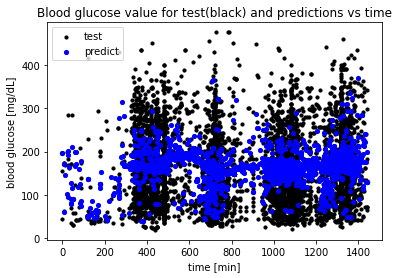

In [71]:
# Plot outputs
plt.scatter(X_test[:,0], y_test, color="black", label='test', s=10)
plt.scatter(X_test[:,0], y_pred_rfr, color="blue", linewidth=2, label='predict', s=10)
plt.title("Blood glucose value for test(black) and predictions vs time")
plt.ylabel('blood glucose [mg/dL]')
plt.xlabel('time [min]')
plt.legend()
plt.show()

This model performed slightly better than the linear one, but the difference is so small that it cannot be said it is a good model. As can be seen from the plot, this time the predicted values are not only limited to the range between 100 and 200. The data is not fitted well to the model as can be seen from the r² score and the errors are still very high.

<h1>Optimizing random forest regression model</h1>

This bit of code, that takes quite a lot of time to run, was run to optimize the models parameters.

In [40]:
#GRIDSEARCH
n_estimators = [50*k for k in range(1,11)]
max_depths = [5*k for k in range(1,21)]

#init
min_RMSE = 1000 # arbitrarily set
best_estimator = 0
best_depth = 0
RMSE = np.zeros(shape=[len(n_estimators), len(max_depths)])

# We are looking for the parameters that minimize the RMSE
if 1 == 2: # to run the code, delete this if
    for estimator_id, estimator in enumerate(n_estimators):
        for depth_id, depth in enumerate(max_depths):

            regressor = RandomForestRegressor(n_estimators=estimator, random_state=1, max_depth=depth)
            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)

            RMSE_val = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

            RMSE[estimator_id][depth_id] = RMSE_val

            if RMSE_val <= min_RMSE :
                best_estimator = estimator
                best_depth = depth
                min_RMSE = RMSE_val

    print("best estimator: ", best_estimator)
    print("best depth: ", best_depth)
    print("min RMSE: ", min_RMSE)

<h1>Correlation heatmap</h1>
A correlation heatmap was visualised to see if there were any interesting features in the more complicated model with separate inputs for exercise, meals, and more. As can be seen from the heatmap, very few features have a high correlation with each other, and those that have a high correlation with each other are explained by the fact that one of them is derived from the other. This is the case, for instance, for <em>exercise</em> and <em>code_exercise</em>, where exercise is derived from code exercise.

<AxesSubplot:>

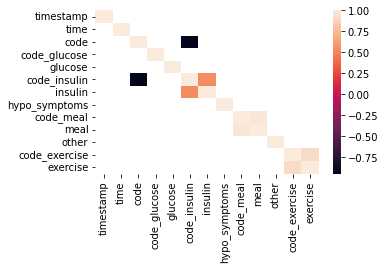

In [41]:
#change category back to int to use heatmap of correlations
cols_cat = ['code_glucose', 'code_insulin', 'code', 'other', 'hypo_symptoms',
            'code_meal','meal', 'code_exercise', 'exercise']
data[cols_cat] = data[cols_cat].astype(int)

# plot heatmap of correlations
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

corr = data.corr()
kot = corr[abs(corr)>=.5] #select only correlations above abs(.5), which is already fairly low

plt.figure(figsize=(5, 3))
sns.heatmap(kot)

<h1>Random forest regressor with more inputs</h1>

Seeing that the previous models failed at predicting the blood glucose in an accurate way, the following model that takes all the imputs from the code separatly was tested, to see if it would perform better. From the heatmap above, it was suspected that the model would not be great either.<br>
The following model takes as imputs separately: 
<ul>
    <li>time (in minutes)</li> 
    <li>insulin injection (0 if no injection)</li>
    <li>hypoglycemic symptoms (binary true or false)</li>
    <li>meal (scale from 0 to 3)</li> 
    <li>if there is any unspecified event (binary true or false)</li>
    <li>exercise (from 0 to 3)</li>
</ul>    
These values have all been derived from the code in the cleaning part of the data. This model generally yields better results than just imputting the time and the code, as previously done.

In [42]:
# SPLITTING THE DATA
X_complex = data[['time', 'insulin', 'hypo_symptoms', 'meal', 'other', 'exercise']]
y_complex = data['glucose']
X_train_complex, X_test_complex, y_train_complex, y_test_complex = train_test_split(X_complex, y_complex, test_size = 0.33, random_state=1)


# MODEL
#instantiation of the model, parameters based on the gridsearch performed below, to find the optimal amount of estimators and depth
regr_complex = RandomForestRegressor(n_estimators = 500, random_state = 1, max_depth = 10)

# Fitting the Random Forest Regression model to the data
regr_complex.fit(X_train_complex, y_train_complex)

# Predicting the target values of the test set
y_pred_rfr_complex = regr_complex.predict(X_test_complex)


# EVALUATION OF THE MODEL

#r² score
print("r² score: ", format(r2_score(y_test_complex, y_pred_rfr_complex), '.3f'))

# MSE (means squared error) & RMSE (Root Mean Square Error)
print("MSE: ", format(mean_squared_error(y_test_complex, y_pred_rfr_complex),'.3f'))
print("RMSE: ", format(np.sqrt(mean_squared_error(y_test_complex, y_pred_rfr_complex)),'.3f'))

#MAE (Mean Absolute Error)
print("MAE: ", format(mean_absolute_error(y_test_complex, y_pred_rfr_complex), '.3f'))

r² score:  0.128
MSE:  5980.942
RMSE:  77.337
MAE:  62.193


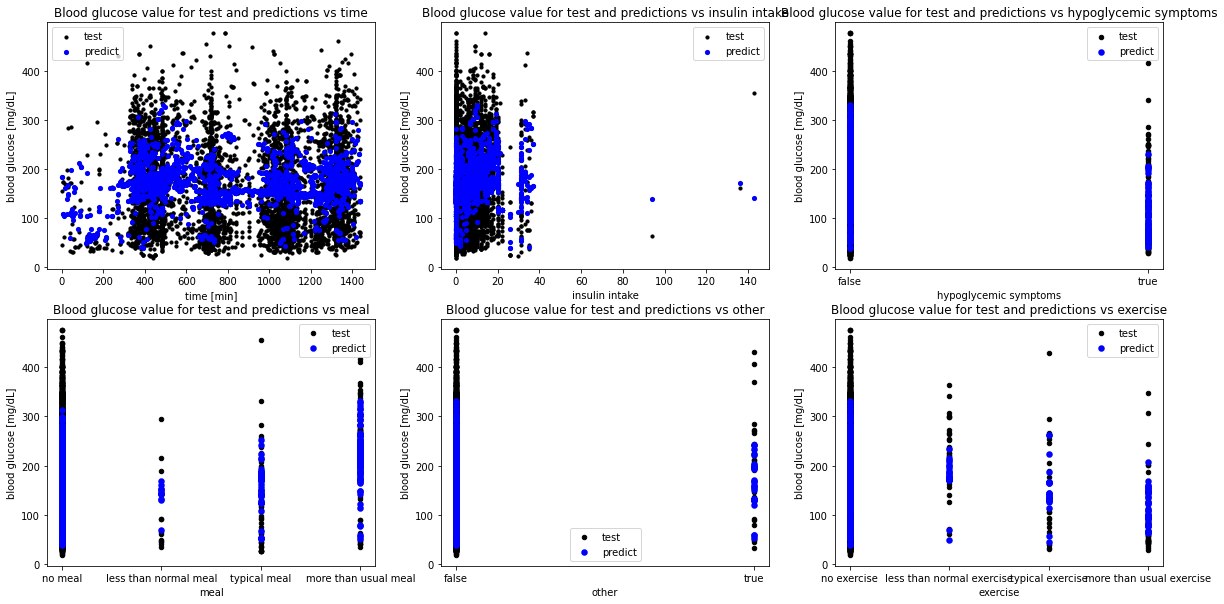

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = np.reshape(axes, -1)

# Plot outputs
axes[0].scatter(X_test_complex.iloc[:,0], y_test_complex, color="black", label='test', s=10)
axes[0].scatter(X_test_complex.iloc[:,0], y_pred_rfr_complex, color="blue", linewidth=2, label='predict', s=10)
axes[0].set(title="Blood glucose value for test and predictions vs time", ylabel='blood glucose [mg/dL]', xlabel='time [min]')
axes[0].legend()

axes[1].scatter(X_test_complex.iloc[:,1], y_test_complex, color="black", label='test', s=10)
axes[1].scatter(X_test_complex.iloc[:,1], y_pred_rfr_complex, color="blue", linewidth=2, label='predict', s=10)
axes[1].set(title="Blood glucose value for test and predictions vs insulin intake", ylabel='blood glucose [mg/dL]', xlabel='insulin intake')
axes[1].legend()

axes[2].scatter(X_test_complex.iloc[:,2], y_test_complex, color="black", label='test', s=20)
axes[2].scatter(X_test_complex.iloc[:,2], y_pred_rfr_complex, color="blue", linewidth=2, label='predict', s=20)
axes[2].set(title="Blood glucose value for test and predictions vs hypoglycemic symptoms", ylabel='blood glucose [mg/dL]', xlabel='hypoglycemic symptoms')
axes[2].set_xticks([0,1], ['false', 'true'])
axes[2].legend()

axes[3].scatter(X_test_complex.iloc[:,3], y_test_complex, color="black", label='test', s=20)
axes[3].scatter(X_test_complex.iloc[:,3], y_pred_rfr_complex, color="blue", linewidth=2, label='predict', s=20)
axes[3].set(title="Blood glucose value for test and predictions vs meal", ylabel='blood glucose [mg/dL]', xlabel='meal')
axes[3].set_xticks([0,1,2,3], ['no meal', 'less than normal meal', 'typical meal', 'more than usual meal'])
axes[3].legend()

axes[4].scatter(X_test_complex.iloc[:,4], y_test_complex, color="black", label='test', s=20)
axes[4].scatter(X_test_complex.iloc[:,4], y_pred_rfr_complex, color="blue", linewidth=2, label='predict', s=20)
axes[4].set(title="Blood glucose value for test and predictions vs other", ylabel='blood glucose [mg/dL]', xlabel='other')
axes[4].set_xticks([0,1], ['false', 'true'])
axes[4].legend()


axes[5].scatter(X_test_complex.iloc[:,5], y_test_complex, color="black", label='test', s=20)
axes[5].scatter(X_test_complex.iloc[:,5], y_pred_rfr_complex, color="blue", linewidth=2, label='predict', s=20)
axes[5].set(title="Blood glucose value for test and predictions vs exercise", ylabel='blood glucose [mg/dL]', xlabel='exercise')
axes[5].set_xticks([0,1,2,3], ['no exercise', 'less than normal exercise', 'typical exercise', 'more than usual exercise'])
axes[5].legend()

The model performs slightly better, but the data still fits poorly to the model and there is a very big error.

<h1>Effect of exercise on blood sugar</h1>
Finally the effect of exercise on blood sugar was verified.<br>
NB: whether this data is actually intersting is debatable, since the exercise blood glucose values are interpolated from the nearest data point with a blood glucose measurment and the assumption that exercise immediatly reduces the blood sugar is made, which is obviously not the case in real life. More parameters that weren't taken into account in this dataset also play a role.

In [44]:
# Caluclate mean, median and standard deviation
means_by_exercise= data.groupby('exercise')['glucose'].mean()
median_by_exercise= data.groupby('exercise')['glucose'].median()
std_by_exercise= data.groupby('exercise')['glucose'].std()
var_by_exercise= data.groupby('exercise')['glucose'].var()
y_axis = [0,1,2,3]

# Initialize data to Dicts of series.
ex = ['no exercise', 'less than normal exercise', 'typical exercise', 'more than normal exercise']
d = {'exercise' : pd.Series(ex, index = y_axis),
     'mean' : pd.Series(means_by_exercise, index = y_axis),
     'median' : pd.Series(median_by_exercise, index = y_axis),
     'std' : pd.Series(std_by_exercise, index = y_axis),
     'var' : pd.Series(var_by_exercise, index = y_axis)}
 
# creates Dataframe.
df = pd.DataFrame(d)
df

,exercise,mean,median,std,var
0,no exercise,162.380660,151.0,82.663950,6833.328621
1,less than normal exercise,216.408163,218.5,70.266039,4937.316221
2,typical exercise,132.794118,105.0,93.608036,8762.464442
3,more than normal exercise,102.187050,71.0,75.497055,5699.805338


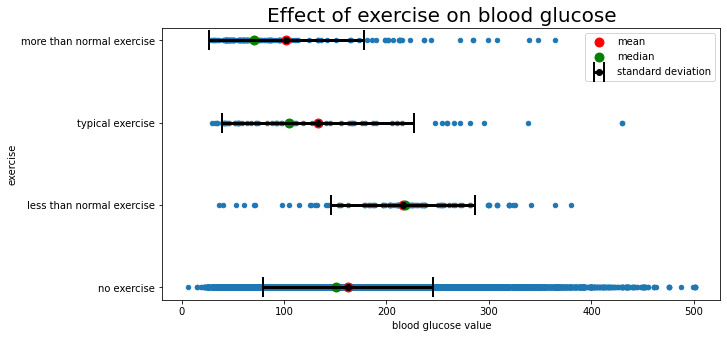

In [45]:
my_yticks = ['no exercise', 'less than normal exercise', 'typical exercise', 'more than normal exercise']

plt.figure(figsize=(10, 5))
plt.scatter(data['glucose'], data['exercise'], s=20)
plt.scatter(means_by_exercise, y_axis, color='red', label='mean', s=80)
plt.scatter(median_by_exercise, y_axis, color='green', label='median', s=80)
plt.errorbar(means_by_exercise, y_axis, xerr=std_by_exercise, fmt='o', capsize=10, capthick=2, elinewidth=3, color='black', label='standard deviation')
plt.yticks(y_axis, my_yticks)
plt.xlabel('blood glucose value')
plt.ylabel('exercise')
plt.title('Effect of exercise on blood glucose', fontsize=20)
plt.legend()

As can be seen in the plot above, with the assumptions that have been made, it seems that exercise has some small effect on blood glucose. However, this effect is not significant, as seen by the error bars on the plot. It would be interesting though to run the same things with data that has more data about exercise (in this dataset, there are only about 300 rows with exercise codes). Also interesting would be to see how exercise affects blood glucose in the hours following the training and during the day, but this dataset doesn't contain enough information to actually accurately assess this.

<h1>Conclusion</h1>
This model should absolutely not be used in a real situation. Its accuracy is not nearly sufficient to be used in potentially life-threatening conditions, such as hypoglycemia or hyperglycemia in diabetic patients. The mean absolute error is over 60, which is pretty high when blood glucose values are between 0 and 500 mg/dL.<br>
Even the model used in the paper cited above, which yields a MAE of about 30, has still too high of an error to actually be used as only reference to predict blood glucose values. In combination with other methods, the algorithm proposed by the paper might be an interesting tool.<br>
The question is also should this data be used to train a model? The dataset is fairly low quality (for instance the units of the values are not specified, not even in the README). The dataset is also extremely incomplete, as in a lot of events aren't documented at all. Some patient mostly have meal information, some have more or less information about meals, and so on. In order to build a usable model, the data on which the algorithm is trained should be more complete (here for instance for patient 3, for the last 3 data points, we only have an insulin value a day, which obviously does not give any information on the blood glucose). With a more complete training dataset, this algorithm might provide some useful insights.<br>
If a model like this should be used in the real world, its accuracy at predictiong blood glucose should be a lot higher. The other problem of this model is that it does not take into account individual patient differences. But with more data from a single patient, the model could be improved to fit said patient better.